# Final Project: San Francisco Crime Classification

###### 41523008
###### 何妮珊
###### 2015级金融智能与信息管理

引入常用包

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
from sklearn import preprocessing

导入数据

In [40]:
trainset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")

# Data Visualization

### Histogram: to show the number of every category of crime

查看目标变量的分布

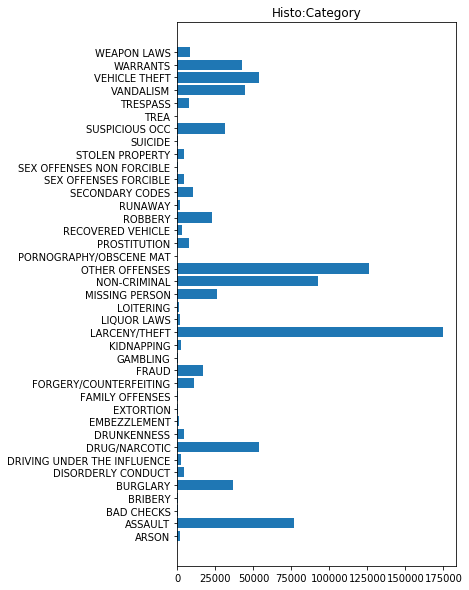

In [54]:
%matplotlib inline

groups = trainset.copy().groupby('Category').size().reset_index(name='category_counts')
plt.figure(figsize=(5,10))
plt.barh(range(len(groups['category_counts'])),groups['category_counts'],tick_label=groups['Category'])
plt.title('Histo:Category')
plt.savefig("Histogram.jpg")
plt.show()

### Heatmap: to show the number of crime distributed in San Francisco(regardless of category)

查看非犯罪和犯罪人员的数量分布，根据热力图颜色可以看到数据量区别

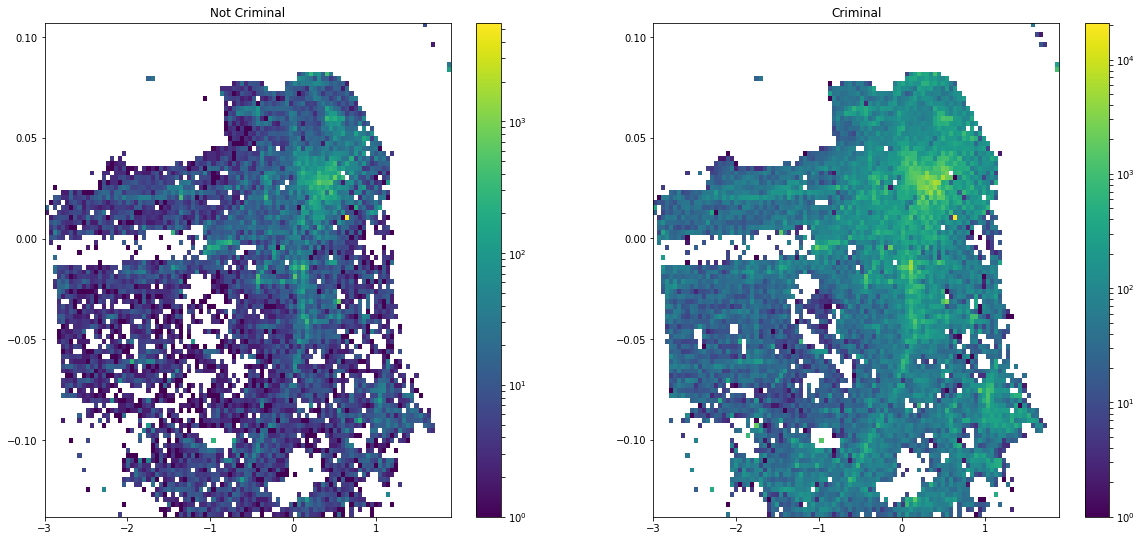

In [43]:
%matplotlib inline

plt.figure(figsize=(30,30))

crimeset = trainset.copy()
#add a new variable to distinguish the criminal and non-criminal
crimeset['isCrime'] = 1

#if not criminal, isCrime column is 0
crimeset.loc[trainset.Category=='NON-CRIMINAL','isCrime']= 0       

####if plot X and Y directly, the result is not satisfying, so process X and Y first.
#Preprocessing: Standard Scale---X and Y
scaler=preprocessing.StandardScaler()
scaler.fit(crimeset[["X","Y"]])
crimeset[["X","Y"]]=scaler.transform(crimeset[["X","Y"]])

#the majority of crime happen only in a small scale, so focus on it
crimeset=crimeset[abs(crimeset["Y"])<100]
crimeset.index=range(len(crimeset))

crimeGroup = crimeset.groupby('isCrime')

#plot a figure----heat map
plt.figure(figsize=(20, 20))
pic = 1
for name, group in crimeGroup:
    plt.subplot(2,2,pic)
    H, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(100,100))
    reextent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(H.T,origin='low',extent = reextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.colorbar()
    if name == 0:
        plt.title('Not Criminal')
    else:
        plt.title('Criminal')
    pic+=1

plt.savefig("Heatmap: Total Crime")


查看每种犯罪类型的地理分布

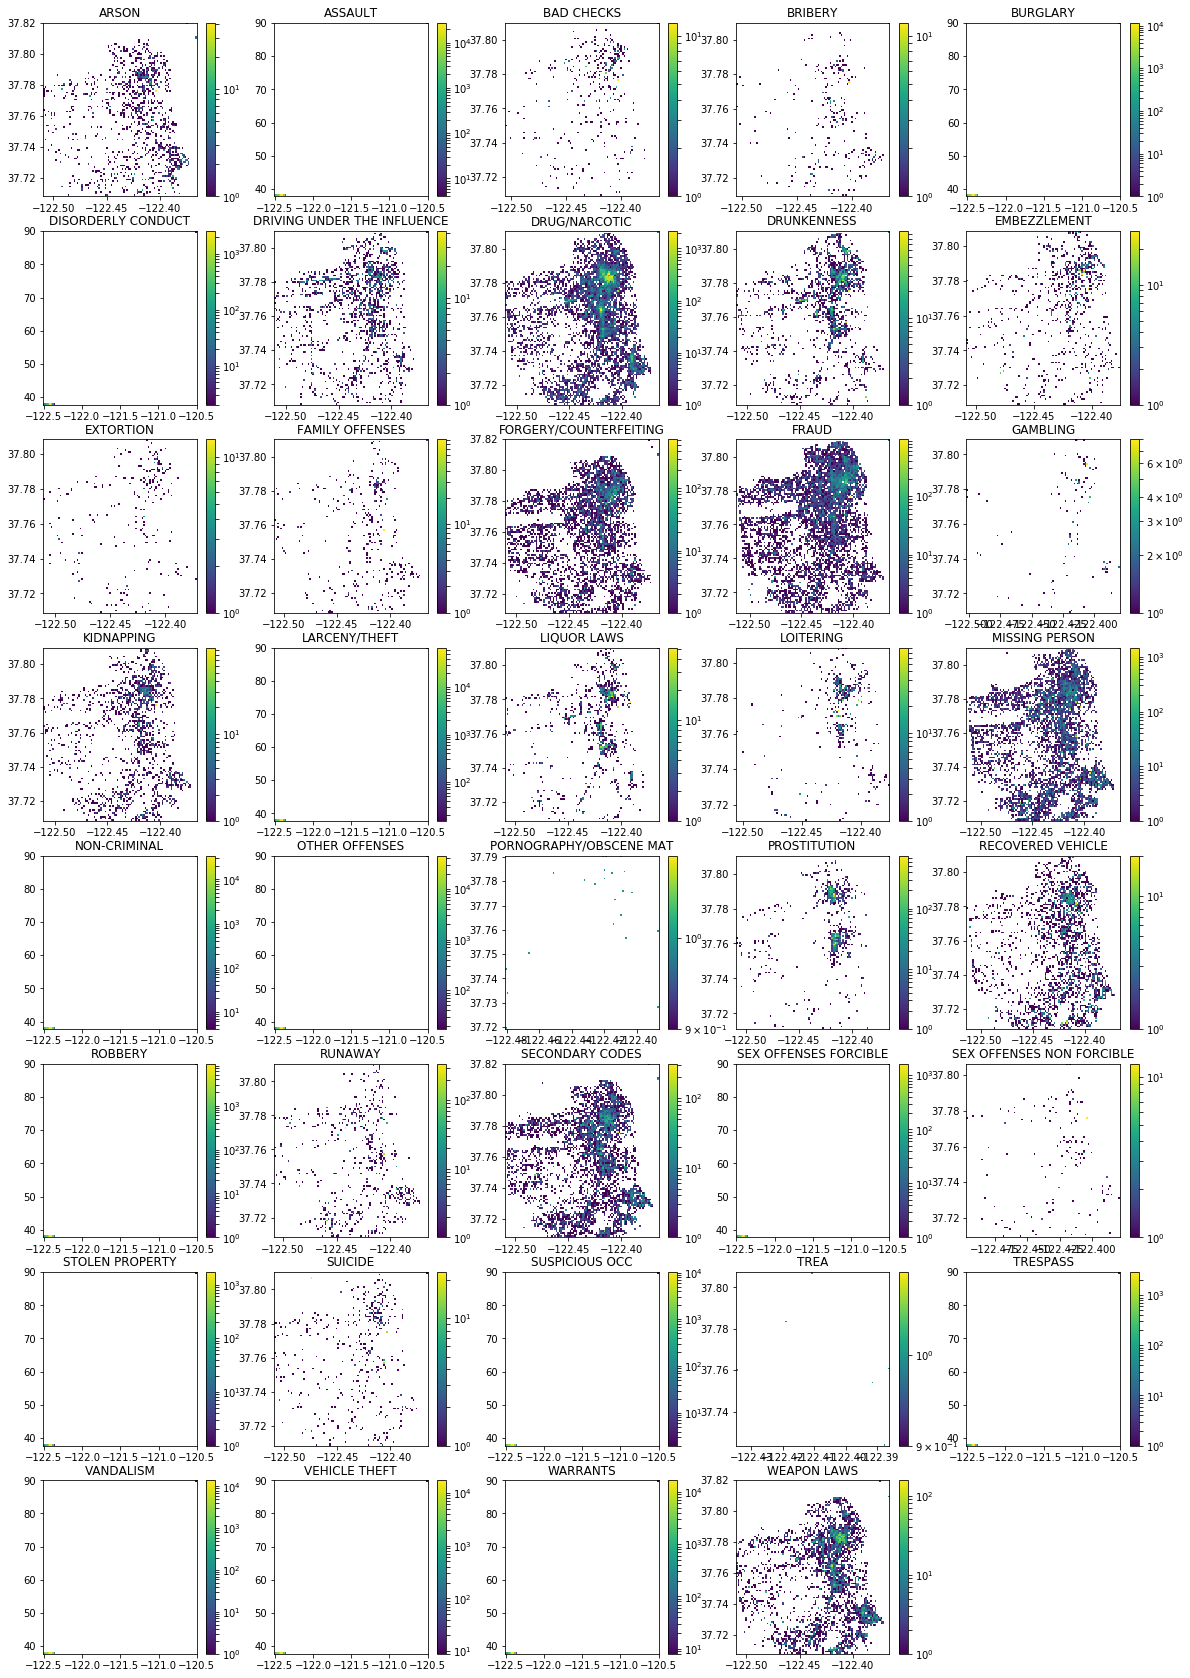

In [56]:
%matplotlib inline

crimeset = trainset.copy()
groups = crimeset.groupby('Category')
pic=1
plt.figure(figsize=(20, 30))
for name, group in groups:
    plt.subplot(8,5,pic)
    H, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(100,100))
    reextent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(H.T,origin='low',extent = reextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.colorbar() 
    plt.title(name)
    pic+=1

plt.savefig("Heatmap: Crime(Category)")

# Preprocessing

In [3]:
#take a glimpse
trainset.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


##### 缺失值探索
结果：不存在缺失值

In [3]:
#see if there are some missing values
#trainset[trainset.isnull().values==True]
print(trainset.isnull().any())
print(testset.isnull().any())
#print(testset.columns)

Dates         False
Category      False
Descript      False
DayOfWeek     False
PdDistrict    False
Resolution    False
Address       False
X             False
Y             False
dtype: bool
Id            False
Dates         False
DayOfWeek     False
PdDistrict    False
Address       False
X             False
Y             False
dtype: bool


##### 哑编码操作
将Category和PdDistrict进行哑编码操作

In [31]:
#target variable：Category, it's qualitative variable，so dummy code it

category = pd.Categorical(trainset.Category)
trainset['Category'] = category.codes
#trainset.head()

#other dummy coding：PdDistrict
trainset['PdDistrict'] = pd.Categorical(trainset.PdDistrict).codes
testset['PdDistrict'] = pd.Categorical(testset.PdDistrict).codes

trainset.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,37,WARRANT ARREST,Wednesday,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,21,TRAFFIC VIOLATION ARREST,Wednesday,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,21,TRAFFIC VIOLATION ARREST,Wednesday,4,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,Wednesday,4,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,Wednesday,5,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


保存目标变量Category的哑编码对应值，方便最后的输出

In [32]:
category_value = category.get_values()
category_code = category.codes
target_df = pd.DataFrame()
target_df['Name'] = category_value
target_df['Code'] = category_code
#if inplace is True: alter the original DataFrame
target_df.drop_duplicates('Name', keep='first', inplace=True)
#change DataFrame to dictionary: for faster query(in clustering procedure)
dict_target = target_df.set_index('Name').T.to_dict('list')
dict_target

{'ARSON': [0],
 'ASSAULT': [1],
 'BAD CHECKS': [2],
 'BRIBERY': [3],
 'BURGLARY': [4],
 'DISORDERLY CONDUCT': [5],
 'DRIVING UNDER THE INFLUENCE': [6],
 'DRUG/NARCOTIC': [7],
 'DRUNKENNESS': [8],
 'EMBEZZLEMENT': [9],
 'EXTORTION': [10],
 'FAMILY OFFENSES': [11],
 'FORGERY/COUNTERFEITING': [12],
 'FRAUD': [13],
 'GAMBLING': [14],
 'KIDNAPPING': [15],
 'LARCENY/THEFT': [16],
 'LIQUOR LAWS': [17],
 'LOITERING': [18],
 'MISSING PERSON': [19],
 'NON-CRIMINAL': [20],
 'OTHER OFFENSES': [21],
 'PORNOGRAPHY/OBSCENE MAT': [22],
 'PROSTITUTION': [23],
 'RECOVERED VEHICLE': [24],
 'ROBBERY': [25],
 'RUNAWAY': [26],
 'SECONDARY CODES': [27],
 'SEX OFFENSES FORCIBLE': [28],
 'SEX OFFENSES NON FORCIBLE': [29],
 'STOLEN PROPERTY': [30],
 'SUICIDE': [31],
 'SUSPICIOUS OCC': [32],
 'TREA': [33],
 'TRESPASS': [34],
 'VANDALISM': [35],
 'VEHICLE THEFT': [36],
 'WARRANTS': [37],
 'WEAPON LAWS': [38]}

将星期变量DayOfWeek转换成数值

In [33]:
#DayOfWeek
#convert it into numbers
#the day of a week is ordered, so we should set the number of each day
def trans_week(day):   
    """ Return the index of a week by the name of the day in a week
    """
    
    week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    return week.index(day) + 1
           
trainset['DayOfWeek'] = trainset['DayOfWeek'].apply(trans_week)
testset['DayOfWeek'] = testset['DayOfWeek'].apply(trans_week)

trainset.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,37,WARRANT ARREST,3,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,21,TRAFFIC VIOLATION ARREST,3,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,21,TRAFFIC VIOLATION ARREST,3,4,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,3,4,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,3,5,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


处理时间变量Dates
* 提取年、月、日、时、分、秒等信息
* 产生新变量：Year,Month,Day,Time,Season

In [34]:
#Dates
import time
####1####
##pick up year, month, day, and time from 'Dates'##
def handle_datetime(dates):
    timeArray = time.strptime(dates, "%Y-%m-%d %H:%M:%S")
    year = timeArray.tm_year
    month = timeArray.tm_mon
    day = timeArray.tm_mday
    times = timeArray.tm_hour*3600 + timeArray.tm_min*60 + timeArray.tm_sec
    return year,month,day,times

#unzip the packing tuple
trainset['Year'],trainset['Month'],trainset['Day'],trainset['Time'] = zip(*trainset['Dates'].apply(handle_datetime))
testset['Year'],testset['Month'],testset['Day'],testset['Time'] = zip(*testset['Dates'].apply(handle_datetime))

#maybe the crime has something to do with the season
#add a new column: season(according to month)

def handle_season(month):
    if month in range(3,6):
        return 1
    elif month in range(6,9):
        return 2
    elif month in range(9,12):
        return 3
    else:
        return 4

trainset['Season'] = trainset['Month'].apply(handle_season)
testset['Season'] = testset['Month'].apply(handle_season)

trainset.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Time,Season
0,2015-05-13 23:53:00,37,WARRANT ARREST,3,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,85980,1
1,2015-05-13 23:53:00,21,TRAFFIC VIOLATION ARREST,3,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,85980,1
2,2015-05-13 23:33:00,21,TRAFFIC VIOLATION ARREST,3,4,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,84780,1
3,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,3,4,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,84600,1
4,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,3,5,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,84600,1


处理X和Y
* 标准化处理

In [35]:
#X and Y
#Preprocessing: Standard Scale---X and Y
location_X = trainset['X']
location_Y = trainset['Y']
scaler = preprocessing.StandardScaler()
scaler.fit(trainset[["X","Y"]])
trainset[["X","Y"]] = scaler.transform(trainset[["X","Y"]])
testset[["X","Y"]] = scaler.transform(testset[["X","Y"]])

trainset.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Time,Season
0,2015-05-13 23:53:00,37,WARRANT ARREST,3,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.107902,0.007832,2015,5,13,85980,1
1,2015-05-13 23:53:00,21,TRAFFIC VIOLATION ARREST,3,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.107902,0.007832,2015,5,13,85980,1
2,2015-05-13 23:33:00,21,TRAFFIC VIOLATION ARREST,3,4,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-0.057541,0.064335,2015,5,13,84780,1
3,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,3,4,NONE,1500 Block of LOMBARD ST,-0.144262,0.065338,2015,5,13,84600,1
4,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,3,5,NONE,100 Block of BRODERICK ST,-0.531112,0.001140,2015,5,13,84600,1


处理地址变量
* 产生新变量：isBlock（是否发生在街区）

In [36]:
#Address
#Did the crime happen in a block or not: transferring the 'Address' to 'isBlock'
#two values: 1(the Address contains 'Block') and 0(the Address contains '/', refering to the interection of 
#two roads(street and Avenue))

def handle_address(add):
    if 'Block' in add:
        return 1
    else:
        return 0
trainset['isBlock'] = trainset['Address'].apply(handle_address)
testset['isBlock'] = testset['Address'].apply(handle_address)

trainset.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Time,Season,isBlock
0,2015-05-13 23:53:00,37,WARRANT ARREST,3,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.107902,0.007832,2015,5,13,85980,1,0
1,2015-05-13 23:53:00,21,TRAFFIC VIOLATION ARREST,3,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.107902,0.007832,2015,5,13,85980,1,0
2,2015-05-13 23:33:00,21,TRAFFIC VIOLATION ARREST,3,4,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-0.057541,0.064335,2015,5,13,84780,1,0
3,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,3,4,NONE,1500 Block of LOMBARD ST,-0.144262,0.065338,2015,5,13,84600,1,1
4,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,3,5,NONE,100 Block of BRODERICK ST,-0.531112,0.001140,2015,5,13,84600,1,1


删除变量：Descript和Resolution

In [37]:
#Descript and Resolution
#they two are not in test data set, so delete them
train_set =  trainset.drop(['Descript','Resolution'],axis=1)

train_set.head()

,Dates,Category,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Time,Season,isBlock
0,2015-05-13 23:53:00,37,3,4,OAK ST / LAGUNA ST,-0.107902,0.007832,2015,5,13,85980,1,0
1,2015-05-13 23:53:00,21,3,4,OAK ST / LAGUNA ST,-0.107902,0.007832,2015,5,13,85980,1,0
2,2015-05-13 23:33:00,21,3,4,VANNESS AV / GREENWICH ST,-0.057541,0.064335,2015,5,13,84780,1,0
3,2015-05-13 23:30:00,16,3,4,1500 Block of LOMBARD ST,-0.144262,0.065338,2015,5,13,84600,1,1
4,2015-05-13 23:30:00,16,3,5,100 Block of BRODERICK ST,-0.531112,0.001140,2015,5,13,84600,1,1


In [11]:
train_set.describe()

,Category,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Time,Season,isBlock
count,878049.000000,878049.000000,878049.000000,8.780490e+05,8.780490e+05,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000
mean,19.338687,3.992691,4.445310,5.777453e-13,-1.040711e-14,2008.712046,6.436509,15.570623,49494.858260,2.466809,0.702957
std,10.688637,1.972023,2.863715,1.000001e+00,1.000001e+00,3.631194,3.428972,8.783005,23616.231316,1.122007,0.456956
min,0.000000,1.000000,0.000000,-2.998840e+00,-1.381971e-01,2003.000000,1.000000,1.000000,60.000000,1.000000,0.000000
25%,16.000000,2.000000,2.000000,-3.404912e-01,-4.069427e-02,2006.000000,3.000000,8.000000,34200.000000,1.000000,0.000000
50%,20.000000,4.000000,4.000000,2.041550e-01,9.631161e-03,2009.000000,6.000000,16.000000,53100.000000,2.000000,1.000000
75%,25.000000,6.000000,7.000000,5.158463e-01,2.921524e-02,2012.000000,9.000000,23.000000,68400.000000,3.000000,1.000000
max,38.000000,7.000000,9.000000,6.334063e+01,1.143134e+02,2015.000000,12.000000,31.000000,86340.000000,4.000000,1.000000


（Time也可以这样处理：凌晨、早上、中午、下午、晚上，处理成区间）

查看每个变量分布

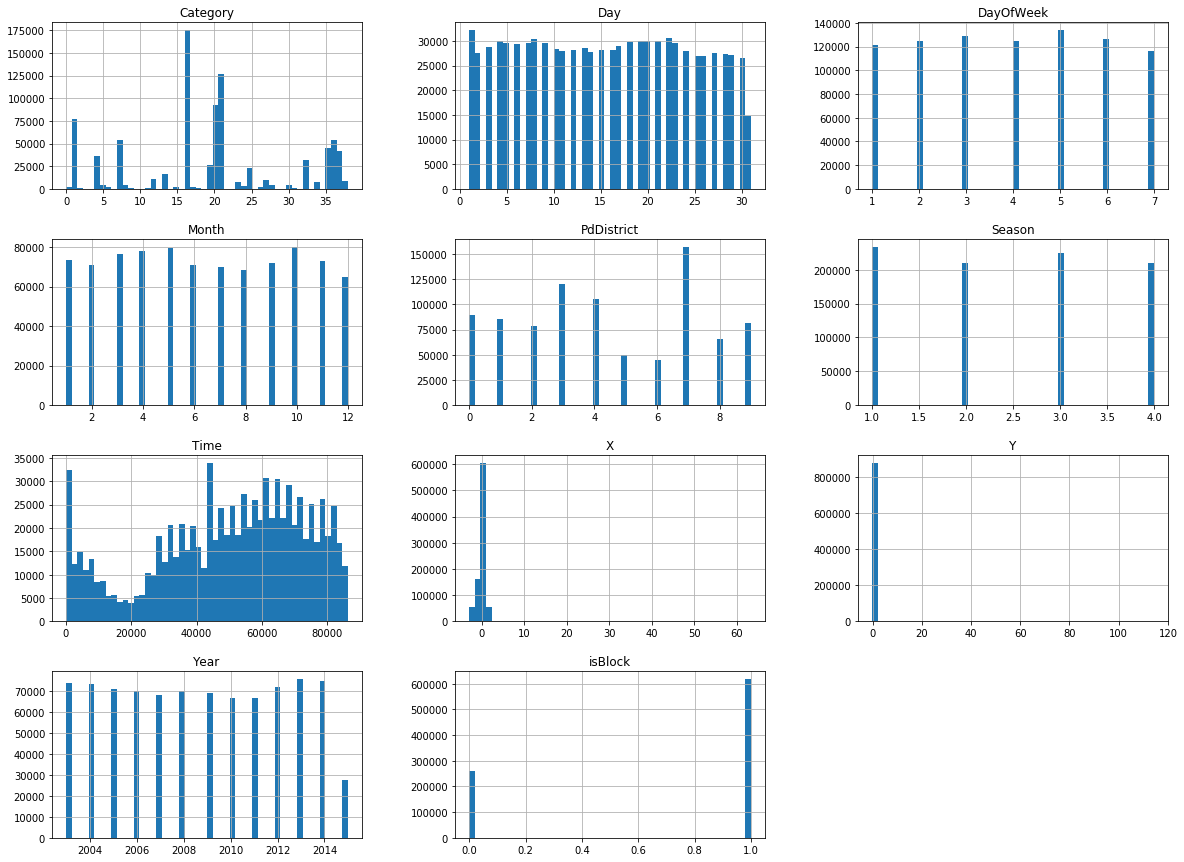

In [38]:
#observe the distribution of every variable
%matplotlib inline
trainset.hist(bins=50, figsize=(20,15))
plt.show()

# Picking Feautures

#### 特征选择

选择初始特征变量

In [12]:
#assign the feature data set
raw_feature = train_set[['DayOfWeek','PdDistrict','X','Y','Year','Month','Day','Time','Season','isBlock']]
raw_feature.head()

,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Time,Season,isBlock
0,3,4,-0.107902,0.007832,2015,5,13,85980,1,0
1,3,4,-0.107902,0.007832,2015,5,13,85980,1,0
2,3,4,-0.057541,0.064335,2015,5,13,84780,1,0
3,3,4,-0.144262,0.065338,2015,5,13,84600,1,1
4,3,5,-0.531112,0.001140,2015,5,13,84600,1,1


##### 相关性分析
* 探查每个变量和目标变量的相关性

In [13]:
# explore the correlation between features and target 
corr_matrix = train_set.corr()
corr_matrix["Category"].sort_values(ascending=False)

Category      1.000000
Time          0.022454
DayOfWeek     0.001078
Day           0.000805
Month         0.000008
Y            -0.000414
Season       -0.001267
Year         -0.021803
X            -0.024401
PdDistrict   -0.040674
isBlock      -0.062806
Name: Category, dtype: float64

##### 随机森林特征选择法

In [16]:
#1# Random Forest: pick important features
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier 
import datetime
starttime = datetime.datetime.now()
X, y = raw_feature, train_set.Category
clf = RandomForestClassifier()
clf = clf.fit(X, y)

# show the importance index of every feature
print(clf.feature_importances_)

model = SelectFromModel(clf, prefit=True)
features1 = model.transform(X)
features1.shape
endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

[0.08705225 0.02046095 0.16264831 0.16581495 0.08703912 0.0945687
 0.1451398  0.18505577 0.04452108 0.00769907]


(878049, 4)

result: picked 4 features: Time(0.18505577),Y(0.16581495),X(0.16264831),Day(0.1451398)

##### 嵌入法：使用支持向量机选择特征

In [15]:
#2# Embedded
import datetime
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
starttime = datetime.datetime.now()
X, y = raw_feature, train_set.Category
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X,y)

model = SelectFromModel(lsvc, prefit=True)
# get the selected features
features2 = model.transform(X)

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

1440


In [22]:
print(features2.shape)
print(features2[0])

(878049, 9)
[ 3.00000000e+00  4.00000000e+00 -1.07902176e-01  7.83180937e-03
  2.01500000e+03  5.00000000e+00  1.30000000e+01  1.00000000e+00
  0.00000000e+00]


so Linear SVC chose 9 columns except Time

other methods considering...

In [ ]:
#3# Wrapper
#Recursive feature elimination method

from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import datetime
starttime = datetime.datetime.now()
X, y = raw_feature, train_set.Category

svc = LinearSVC(C=1)
rfe = RFE(estimator=svc, n_features_to_select=2, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_
print(ranking)

#ref2 = RFE(estimator=LogisticRegression(), n_features_to_select=2).fit(X, y)
#print(ref2.ranking_)

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

In [ ]:
#4#
from sklearn.linear_model import RandomizedLogisticRegression
import datetime
starttime = datetime.datetime.now()

X, y = raw_feature, train_set.Category

rlr = RandomizedLogisticRegression()
rlr.fit(X, y) 
egeList=rlr.get_support() #get the selected features
print(egeList)

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

#### 选择了全部的feature

### Fit Model

#### 训练模型

In [14]:
features = raw_feature
feature = ['DayOfWeek','PdDistrict','X','Y','Year','Month','Day','Time','Season','isBlock']

##### 划分训练集和测试集

In [15]:
# split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, train_set.Category, test_size=0.4, random_state=42)

In [16]:
X_train.shape

(526829, 10)

In [17]:
y_train.shape

(526829,)

In [18]:
X_test.shape

(351220, 10)

In [19]:
y_test.shape

(351220,)

In [12]:
#split training and testing set
#分层抽样，正负样本比例相同
#舍弃：涉及需要预测的目标变量值很多，不能简单使用这个正负样本抽取的方法
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_set, train_set.Category):
    strat_train_set = train_set.loc[train_index]
    x_strat_train = strat_train_set[feature]
    y_strat_train = strat_train_set.Category
    strat_test_set = train_set.loc[test_index]
    x_strat_test = strat_test_set[feature]
    y_strat_test = strat_test_set.Category

#### 逻辑回归模型

In [248]:
#1# Logistic Regression
from sklearn.linear_model import LogisticRegression
import datetime
starttime = datetime.datetime.now()

lr = LogisticRegression() 
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))  # accuracy
y_pred_test_lr = lr.predict(X_test)

#print(u'模型的平均正确率：%s' % lr.score(X_train, y_train)) 

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

0.1985293140658544
194


查看误差

In [249]:
from sklearn.metrics import mean_squared_error

lr_mse = mean_squared_error(y_test, y_pred_test_lr)
lr_smse = np.sqrt(lr_mse)
lr_smse

1.5215579711367029

#### 支持向量机模型

In [25]:
#2# Linear SVC
from sklearn.svm import LinearSVC
import datetime
starttime = datetime.datetime.now()
ls = LinearSVC(C=0.8)
ls.fit(X_train, y_train)
print(ls.score(X_train, y_train))  # accuracy

y_pred_train_ls = ls.predict(X_train)

#print(ls.score(X_test, y_test))
y_pred_test_ls = ls.predict(X_test)
#print(show_accuracy(y_pred_test_ls, y_test, '测试集'))

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

0.10359908053656879
5494


In [17]:
from sklearn.metrics import mean_squared_error
ls_s_mse = mean_squared_error(y_srtat_test, y_pred_test_ls_s)
ls_s_smse = np.sqrt(-ls_s_mse)
ls_s_smse

3.779765418090965

#### 斜度提升分类器

In [12]:
#3# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
import datetime
starttime = datetime.datetime.now()
gbr = GradientBoostingClassifier()
gbr.fit(X_train, y_train)
print(gbr.score(X_train, y_train))  # accuracy
y_pred_test_gbr = gbr.predict(X_test)

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

0.2795043553031439
5359


In [14]:
from sklearn.metrics import mean_squared_error
gbr_mse = mean_squared_error(y_test, y_pred_test_gbr)
gbr_smse = np.sqrt(-gbr_mse)
gbr_smse

2.1608875750245957

#### K最邻近分类器

In [217]:
#4# KNeighborsClassfier
from sklearn.neighbors import KNeighborsClassifier
import datetime
starttime = datetime.datetime.now()

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))
y_pred_test_knn = knn.predict(X_test)

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

0.4095104863247847
51


In [218]:
from sklearn.metrics import mean_squared_error
knn_mse = mean_squared_error(y_test, y_pred_test_knn)
knn_smse = np.sqrt(-knn_mse)
knn_smse

2.5727759356448656

> 选择出了两个模型
* 逻辑回归
* K最邻近分类器
#####  再次做模型评估

#### 逻辑回归

In [250]:
#logistic regression
y_pred_test_lr.tolist()
y_test_list = list(y_test)

因为目标变量不是一个简单的二分类问题，不能使用auc、precision等评估方式

In [251]:
from sklearn import metrics


#print('AUC: %.4f' % metrics.roc_auc_score(y_test_list,y_pred_test_knn))
print('ACC: %.4f' % metrics.accuracy_score(y_test_list,y_pred_test_lr))
#print('Recall: %.4f' % metrics.recall_score(y_test_list,y_pred_test_knn))
#print('F1-score: %.4f' %metrics.f1_score(y_test_list,y_pred_test_knn)) 
#print('Precesion: %.4f' %metrics.precision_score(y_test_list,y_pred_test_knn)) 
#metrics.confusion_matrix(y_test_list,y_pred_test_knn)

ACC: 0.1982


#### K最邻近分类器

In [243]:
#KNeighbor
y_pred_test_knn_list = list(y_pred_test_knn)
y_test_list = list(y_test)

In [247]:
from sklearn import metrics

# 设置阈值, 输出一些评价指标
#y_pred_knn = (y_pred_test_knn >= 0.5)*1
#print('AUC: %.4f' % metrics.roc_auc_score(y_test_list,y_pred_test_knn_list))
print('ACC: %.4f' % metrics.accuracy_score(y_test_list,y_pred_test_knn_list))
#print('Recall: %.4f' % metrics.recall_score(y_test_list,y_pred_test_knn))
#print('F1-score: %.4f' %metrics.f1_score(y_test_list,y_pred_test_knn)) 
#print('Precesion: %.4f' %metrics.precision_score(y_test_list,y_pred_test_knn),average='macro') 
#metrics.confusion_matrix(y_test_list,y_pred_test_knn_list)

ACC: 0.1829


In [190]:
type(y_train)

pandas.core.series.Series

In [200]:
type(X_train)

pandas.core.frame.DataFrame

### 尝试XGBoost模型

其训练、评估、调参、预测都一起放在这里了

准备数据和参数

In [210]:
#5# XGBoosting

import xgboost as xgb

train_data = np.array(X_train)
train_label = np.array(y_train)
val_data = np.array(X_test)
val_label = np.array(y_test)
test_data = np.array(testset[feature])

dtrain = xgb.DMatrix(train_data,label=train_label)
dval = xgb.DMatrix(val_data,label=val_label)
dtest = xgb.DMatrix(test_data)

params={
    'booster':'gbtree',
    'objective': 'multi:softprob',
    'gamma':0.1,
    'max_depth':4,
    'lambda':10,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'eval_metric':'merror',
    'num_class':39,
    'eta': 0.007,
    'seed':1000,
    'nthread':8,
    'silent':0}
#multi: softprob
#'eval_metric': 'auc' id not acceptable

watchlist = [(dval,'eval'),(dtrain,'train')]

训练、验证和预测

In [211]:
import datetime
starttime = datetime.datetime.now()

num_boost_round = 100
plst = params.items()

#train the model
bst = xgb.train(plst,dtrain,num_boost_round,watchlist)

y_pred_xgb = bst.predict(dtest)

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

[0]	eval-merror:0.761098	train-merror:0.762004
[1]	eval-merror:0.759863	train-merror:0.759383
[2]	eval-merror:0.757118	train-merror:0.757363
[3]	eval-merror:0.758391	train-merror:0.758468
[4]	eval-merror:0.758439	train-merror:0.758755
[5]	eval-merror:0.756774	train-merror:0.756764
[6]	eval-merror:0.755367	train-merror:0.755566
[7]	eval-merror:0.754362	train-merror:0.754533
[8]	eval-merror:0.755287	train-merror:0.755429
[9]	eval-merror:0.754587	train-merror:0.754657
[10]	eval-merror:0.75445	train-merror:0.754734
[11]	eval-merror:0.754268	train-merror:0.754547
[12]	eval-merror:0.753946	train-merror:0.754305
[13]	eval-merror:0.754109	train-merror:0.754503
[14]	eval-merror:0.753565	train-merror:0.754099
[15]	eval-merror:0.753476	train-merror:0.754076
[16]	eval-merror:0.754091	train-merror:0.754539
[17]	eval-merror:0.75379	train-merror:0.754345
[18]	eval-merror:0.753821	train-merror:0.754402
[19]	eval-merror:0.753801	train-merror:0.754317
[20]	eval-merror:0.753049	train-merror:0.753446
[21]

In [215]:
y_pred_xgb.shape

(884262, 39)

对XGBoost模型进行调参，找到最优参数组合

In [261]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

# the prepared list of parameters, find their best coombination
xgb_parameters = {'max_depth':[2,4],'n_estimators':[20,50],'reg_alpha':[0.05, 0.2],'reg_lambda':[2, 4]}

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              numpy.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
xgb_testing = XGBClassifier(n_estimators = 20,
                      learning_rate = 0.2,
                      max_depth = 4,
                      min_child_weight=4,
                      gamma = 0.1,
                      reg_alpha = 0.05,
                      reg_lambda = 2,
                      subsample = 1.0,
                      colsample_bytree = 1.0,
                      max_delta_step = 1,
                      scale_pos_weight = 1,
                      objective = 'multi:softprob',
                      nthread = 8,
                      seed = 0#,
                      #silent = False
)

clf_xgb = GridSearchCV(xgb_testing, xgb_parameters, scoring = 'neg_log_loss',verbose=10)
clf_xgb.fit(X_train,y_train)
print(clf_xgb.best_score_)
print(clf_xgb.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=2 ......
[CV]  max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=2, score=-2.5628803323731044, total= 1.4min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=2 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=2, score=-2.561517294162549, total= 1.5min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=2 ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=2, score=-2.563235613958528, total= 1.5min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=4 ......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.5min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=4, score=-2.5629223535512833, total= 1.5min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=4 ......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.3min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=4, score=-2.561461752267854, total= 1.3min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=4 ......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.9min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.05, reg_lambda=4, score=-2.5634776641413017, total= 1.2min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=2 .......


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.5min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=2, score=-2.56291042396304, total= 1.2min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=2 .......


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 12.1min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=2, score=-2.561562073325711, total= 1.2min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=2 .......


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.6min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=2, score=-2.563262856641307, total= 1.3min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=4 .......


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 15.3min remaining:    0.0s


[CV]  max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=4, score=-2.5629340524805038, total= 1.3min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=4 .......
[CV]  max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=4, score=-2.561493324233956, total= 1.2min
[CV] max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=4 .......
[CV]  max_depth=2, n_estimators=20, reg_alpha=0.2, reg_lambda=4, score=-2.563491003516337, total= 1.4min
[CV] max_depth=2, n_estimators=50, reg_alpha=0.05, reg_lambda=2 ......
[CV]  max_depth=2, n_estimators=50, reg_alpha=0.05, reg_lambda=2, score=-2.471801097630163, total= 3.9min
[CV] max_depth=2, n_estimators=50, reg_alpha=0.05, reg_lambda=2 ......
[CV]  max_depth=2, n_estimators=50, reg_alpha=0.05, reg_lambda=2, score=-2.4706392799346917, total= 3.7min
[CV] max_depth=2, n_estimators=50, reg_alpha=0.05, reg_lambda=2 ......
[CV]  max_depth=2, n_estimators=50, reg_alpha=0.05, reg_lambda=2, score=-2.473231076688109, total= 3.9min
[CV] max_d

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 208.7min finished


-2.4017410570689157
{'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 0.05, 'reg_lambda': 2}


使用最佳参数组合模型进行预测，输出结果

In [268]:
#XGBoost predicting
xgb_final_model = clf_xgb.best_estimator_
labels = train_set.Category.unique()
finalResult = xgb_model.predict_proba(testset[feature])
result = pd.DataFrame(finalResult)
result.columns = xgb_model.classes_
result.columns = sorted(target_df['Name'])
result.to_csv("myprediction.csv", index_label="Id", na_rep="0")

### Modify model and predict

从逻辑回归和K最邻近分类器选出更优模型进行调参、预测

设置展示评分函数

In [256]:
def display_scores(scores):
    print("Model result:/n")
    print("Scores:", scores)
    print("/nMean:", scores.mean())
    print("/nStandard deviation:", scores.std())

对逻辑回归函数打分

In [15]:
from sklearn.model_selection import cross_val_score

lr_scores = cross_val_score(lr, X_test, y_test, cv=3)
lr_rmse_scores = np.sqrt(lr_scores)
display_scores(lr_rmse_scores)

Model result:/n
Scores: [0.44489676 0.44499444 0.44441407]
/nMean: 0.4447684242324243
/nStandard deviation: 0.0002537201997822001


对斜度提升分类器打分

In [17]:
from sklearn.model_selection import cross_val_score
gbr_scores = cross_val_score(gbr, X_test, y_test, cv=3)
gbr_scores = np.sqrt(gbr_scores)
display_scores(gbr_scores)

Model result:/n
Scores: [0.14273587 0.13729471 0.14597481 0.12809105 0.14098546 0.14678573
 0.14799016 0.141869   0.14154534 0.14325767]
/nMean: 0.1416529811922887
/nStandard deviation: 0.005406986952616438
None


对K最邻近分类器打分

In [257]:
from sklearn.model_selection import cross_val_score
knn_scores = cross_val_score(knn, X_test, y_test, cv=3)
knn_scores = np.sqrt(knn_scores)
display_scores(knn_scores)

Model result:/n
Scores: [0.4148254  0.4136696  0.41409504]
/nMean: 0.414196679695049
/nStandard deviation: 0.00047729570536485895
None


##### 调整模型参数

找到逻辑回归模型最优参数

In [265]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr_parameters = {'C':[0.1,10,100]}
 
#3-fold
clf_lr = GridSearchCV(LogisticRegression(), lr_parameters, cv=3, scoring='neg_log_loss')
clf_lr.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
#best parameters 
print(clf_lr.best_params_)
print()
print("Grid scores on development set:")
print()
    
for params, mean_score, scores in clf_lr.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"% (mean_score, scores.std() * 2, params))
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
   

Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

-2.673 (+/-0.001) for {'C': 0.1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

-2.673 (+/-0.001) for {'C': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

-2.673 (+/-0.001) for {'C': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



### Predict

#### 使用逻辑回归函数进行预测

In [267]:
#LogisticRegression
target_label = target_df['Name']
result = pd.DataFrame(lr.predict_proba(testset[feature].as_matrix()), columns=sorted(target_label))
result.to_csv("myprediction_lr.csv", index_label="Id", na_rep="0")

# Group Crime

### 聚类分析：寻找团伙犯罪

In [126]:
#find the code of non-criminal
print(dict_target['NON-CRIMINAL'])

[20]


### KMeans聚类分析
* 尝试1到100类
* 画出inertia图像，找到最优聚类数目

7777


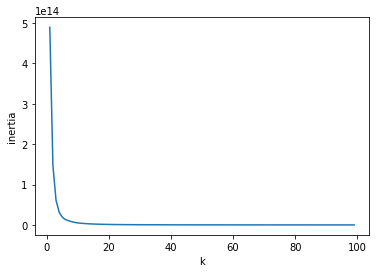

In [20]:
from sklearn.cluster import KMeans
%matplotlib inline
import datetime
import time

#在时间、地点作案的犯罪人员之间若有相似性，有团伙作案的可能
crimeset = train_set.copy()

#drop the non-criminal records
#NON-CRIMINAL:20

innocent_list = list(crimeset.Category)
innocent_list.remove(20)
crimeset[crimeset.Category.isin(innocent_list)]
crimeset['X'] = location_X
crimeset['Y'] = location_Y
crimeGroupData = crimeset[["X","Y","Month","Year","Day","Time"]]
crimeGroup = np.array(crimeGroupData)

starttime = datetime.datetime.now()

# try different k, find the best one
inertias=[] 
label_pred=[] 
centroids=[] 
for k in range(1,100): 
    estimator = KMeans(n_clusters=k) 
    estimator.fit(crimeGroup)
    label_pred.append(estimator.labels_) 
    centroids.append(estimator.cluster_centers_) 
    inertias.append(estimator.inertia_ )

x = range(1,len(inertias) + 1)
plt.plot(x,inertias)
plt.xlabel("k") 
plt.ylabel("inertia")

endtime = datetime.datetime.now()
print((endtime - starttime).seconds)

找到使inertia突变的k

In [22]:
for i in range(10):
    print(inertias[i])

489710625268658.44
147930746105996.6
61644446048774.305
31879693523379.684
19272410600785.547
13527613181226.922
10498853268255.938
8095152237880.106
6265323386024.196
5039072398354.336


展示聚类中心

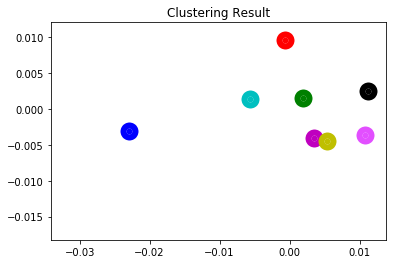

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

n_clusters = 8
cluster = KMeans(n_clusters)
cluster.fit(crimeGroup)
cents = cluster.cluster_centers_
labels = cluster.labels_


#draw the centers of cluster result, using different colors
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
for i in range(n_clusters):
    plt.scatter(cents[i,0], cents[i,1], color=colors[i], linewidths=12)
    
plt.title("Clustering Result")
#plt.axis([-30,30,-30,30])
plt.show()

展示所有数据的分布情况和聚类结果

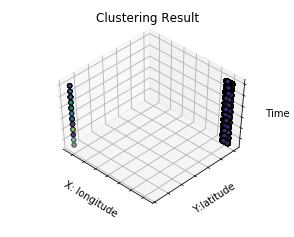

In [24]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
title = 'Clustering Result'

fignum = 1
n_clusters = 8
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
est = KMeans(n_clusters)
est.fit(crimeGroup)
labels = est.labels_

ax.scatter(crimeGroup[:, 0], crimeGroup[:, 1], crimeGroup[:, 2],
        c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('X: longitude')
ax.set_ylabel('Y:latitude')
ax.set_zlabel('Time')
ax.set_title(title)
ax.dist = 12  

In [ ]:
* 添加新变量：

In [26]:
print(labels)
print(labels.shape)
crimeset['Type'] = labels

crimeset.to_csv("groupCrime.csv", index_label="Id", na_rep="0")
crimeset

[5 5 5 ... 1 1 1]
(878049,)


,Dates,Category,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Time,Season,isBlock,Type
0,2015-05-13 23:53:00,37,3,4,OAK ST / LAGUNA ST,-0.107902,0.007832,2015,5,13,85980,1,0,5
1,2015-05-13 23:53:00,21,3,4,OAK ST / LAGUNA ST,-0.107902,0.007832,2015,5,13,85980,1,0,5
2,2015-05-13 23:33:00,21,3,4,VANNESS AV / GREENWICH ST,-0.057541,0.064335,2015,5,13,84780,1,0,5
3,2015-05-13 23:30:00,16,3,4,1500 Block of LOMBARD ST,-0.144262,0.065338,2015,5,13,84600,1,1,5
4,2015-05-13 23:30:00,16,3,5,100 Block of BRODERICK ST,-0.531112,0.001140,2015,5,13,84600,1,1,5
5,2015-05-13 23:30:00,16,3,2,0 Block of TEDDY AV,0.637950,-0.126046,2015,5,13,84600,1,1,5
6,2015-05-13 23:30:00,36,3,2,AVALON AV / PERU AV,-0.023408,-0.100422,2015,5,13,84600,1,0,5
7,2015-05-13 23:30:00,36,3,0,KIRKWOOD AV / DONAHUE ST,1.691468,-0.095113,2015,5,13,84600,1,0,5
8,2015-05-13 23:00:00,16,3,6,600 Block of 47TH AV,-2.819355,0.012215,2015,5,13,82800,1,1,5
9,2015-05-13 23:00:00,16,3,1,JEFFERSON ST / LEAVENWORTH ST,0.116256,0.080503,2015,5,13,82800,1,0,5
